In [ ]:
pip3 install -r requirements.txt

In [1]:
import random
from deap import base, creator, tools, algorithms
import numpy as np
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
import pandas as pd
from functools import partial
from tqdm import tqdm
from math import sqrt

In [2]:
# Global variables

dataset_path = './data/drivetest1.FCdata'
num_pop = 128
num_generations = 4096
num_previous_elites = 16

cxpb = 0.5 # crossover probability
mutpb = 0.2 # mutation probability

eps = 1e-3

In [3]:
df = pd.read_csv(dataset_path, sep='\t', header=None)
df.columns = ['v1', 'v2', 'v3', 'v4', 'd12', 'd23', 'd34']
df

,v1,v2,v3,v4,d12,d23,d34
0,3.869885,4.068808,4.397506,4.217650,7.834755,8.409266,7.151023
1,3.844477,3.991765,4.512394,4.380151,7.814863,8.376396,7.169009
2,3.838882,3.906075,4.611321,4.504225,7.800134,8.324333,7.182233
3,3.856315,3.816075,4.685235,4.585342,7.793415,8.253808,7.192942
4,3.894275,3.727296,4.727835,4.625356,7.797439,8.166892,7.202932
...,...,...,...,...,...,...,...
1884,13.444157,14.059872,14.018554,14.219132,14.553985,22.128316,18.474554
1885,13.413479,14.021347,13.980435,14.224157,14.492413,22.132448,18.454496
1886,13.360894,13.987613,13.942929,14.225414,14.431627,22.136539,18.430124
1887,13.287419,13.966160,13.908387,14.221659,14.368955,22.141008,18.401875


In [4]:
# Prepare dataset

v1 = df['v1'].values
v2 = df['v2'].values
v3 = df['v3'].values
v4 = df['v4'].values
ds12 = df['d12'].values
ds23 = df['d23'].values
ds34 = df['d34'].values
dv12 = v2 - v1
dv23 = v3 - v2
dv34 = v4 - v3

dt = 0.1 # From readme

# acceleration
a1 = np.diff(v1) / dt
a2 = np.diff(v2) / dt
a3 = np.diff(v3) / dt
a4 = np.diff(v4) / dt

In [5]:
def acc_idm(v, s, dv, a, s0, v0, T, b):
    """
    v: velocity
    s: distance between front car
    dv: velocity difference of front car (v - v_front)
    a: acceleration
    s0: minimum distance
    v0: desired velocity
    T: time headway
    b: safe deceleration
    """
    s_star_tmp = v * T + v * dv / (2 * max(eps, sqrt(a*b)))
    s_star_tmp[s_star_tmp < 0] = 0
    s_star = s0 + s_star_tmp
    s[s < eps] = eps
    return a * (1 - (v / max(eps, v0)) ** 4 - (s_star / s) ** 2)

# argument: argmin(rmse(acc_pred, acc_label)) <- v, ds

def rmse(v, s, dv, acc, individual, neg=False):
    a, s0, v0, T, b = individual
    acc_pred = acc_idm(v, s, dv, a, s0, v0, T, b)
    tmp = ((acc_pred - acc) ** 2).mean()
    if neg:
        return -tmp,
    else:
        return tmp,

# To draw the graph, given the ics, iterate to get the results.
def euler_method(Ics, partial_acc_f, steps):
    va, vb0, ds0 = Ics # initial conditions: Front car velocity, Self velocity, distance between them
    acc = []
    vb = [vb0]
    ds = [ds0]
    for i in range(steps):
        acc.append(partial_acc_f(vb[i], ds[i], vb[i] - va[i]))
        vb.append(vb[i] + acc[i] * dt)
        ds.append(ds[i] + (va[i] - vb[i]) * dt)

    return vb, ds

In [6]:
# Setup DEAP
creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
creator.create("Individual", list, fitness=creator.FitnessMin)

toolbox = base.Toolbox()
toolbox.register("attr_float", random.uniform, eps, 1)
toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_float, n=5)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def _eval(ind): # TODO: Fix this
    return partial(rmse, v2[:-1], ds12[:-1], dv12[:-1], a2, neg=False)(ind)

def _mutate(individual, mu, sigma, indpb):
    size = len(individual)
    for i in range(size):
        if random.random() < indpb:
            individual[i] += random.gauss(mu, sigma)
            individual[i] = max(eps, individual[i])
    return individual,

def _crosseover(ind1, ind2, alpha):
    for i in range(len(ind1)):
        ind1[i] = max(eps, (1-alpha)*ind1[i] + alpha*ind2[i])
        ind2[i] = max(eps, alpha*ind1[i] + (1-alpha)*ind2[i])
    return ind1, ind2

toolbox.register("evaluate", _eval)
toolbox.register("mate", _crosseover, alpha=0.5)
toolbox.register("mutate", partial(_mutate, mu=0, sigma=0.1, indpb=0.1))
toolbox.register("select", tools.selTournament, tournsize=3)

population = toolbox.population(n=num_pop)

In [7]:
# Run the algorithm
pbar = tqdm(range(num_generations))
for gen in pbar:
    offspring = algorithms.varAnd(population, toolbox, cxpb=cxpb, mutpb=mutpb)
    fits = toolbox.map(toolbox.evaluate, offspring)
    for fit, ind in zip(fits, offspring):
        ind.fitness.values = fit
    
    # Elitism
    #population = toolbox.select(offspring, k=len(population))
    selected = toolbox.select(offspring, k=len(population) - num_previous_elites)

    elite = tools.selBest(population, num_previous_elites)
    next_generation = elite + selected

    pbar.set_description(f'Best fitness: {tools.selBest(next_generation, k=1)[0].fitness.values[0]}')  

    population[:] = next_generation

Best fitness: 0.37805483702698217: 100%|██████████| 4096/4096 [00:51<00:00, 78.79it/s]


In [14]:
# Plot
def acc_idm_scalar(v, s, dv, a, s0, v0, T, b):
    s_star_tmp = v * T + v * dv / (2 * max(eps, sqrt(a*b)))
    s_star_tmp = max(eps, s_star_tmp)
    s_star = s0 + s_star_tmp
    s = max(eps, s)
    return a * (1 - (v / max(eps, v0)) ** 4 - (s_star / s) ** 2)

def scalar_rmse(y, y_pred):
    return sqrt(mean_squared_error(y, y_pred))

def plot_estimation(v_front, v_self, ds, best_ind):
    pred = euler_method([v_front, v_self[0], ds[0]], partial(acc_idm_scalar, a=best_ind[0], s0=best_ind[1], v0=best_ind[2], T=best_ind[3], b=best_ind[4]), len(v_front))
    # Plot two figure
    plt.figure(figsize=(20, 10))
    ax = plt.subplot(2, 1, 1)
    v_self_pred, ds_pred = pred
    ts = np.arange(0, len(v_front) * dt, dt)
    plt.plot(ts, v_self, label='v_self_label')
    plt.plot(ts, v_self_pred[:-1], label='v_self_pred')
    plt.title('velocity vs time')
    ax.set_xlabel('time')
    ax.set_ylabel('velocity')
    plt.legend()
   
    ax = plt.subplot(2, 1, 2)
    plt.plot(ts, ds, label='ds_label')
    plt.plot(ts, ds_pred[:-1], label='ds_pred')
    ax.set_xlabel('time')
    ax.set_ylabel('distance')
    plt.legend()
    print('Best individual: ', best_ind)
    print('RMSE dv/dt pred: ', rmse(v1[:-1], ds12[:-1], dv12[:-1], a1, best_ind)[0])
    print(f'RMSE v|s pred: {scalar_rmse(v_self, v_self_pred[:-1])}, {scalar_rmse(ds, ds_pred[:-1])}')
    plt.show()

Best individual:  [0.9402817238836121, 4.785098766078083, 90.11450011543174, 0.7027691621312041, 2.185699634202386]
RMSE dv/dt pred:  0.4960080596218259
RMSE v|s pred: 0.8588647856138406, 4.293029690626431


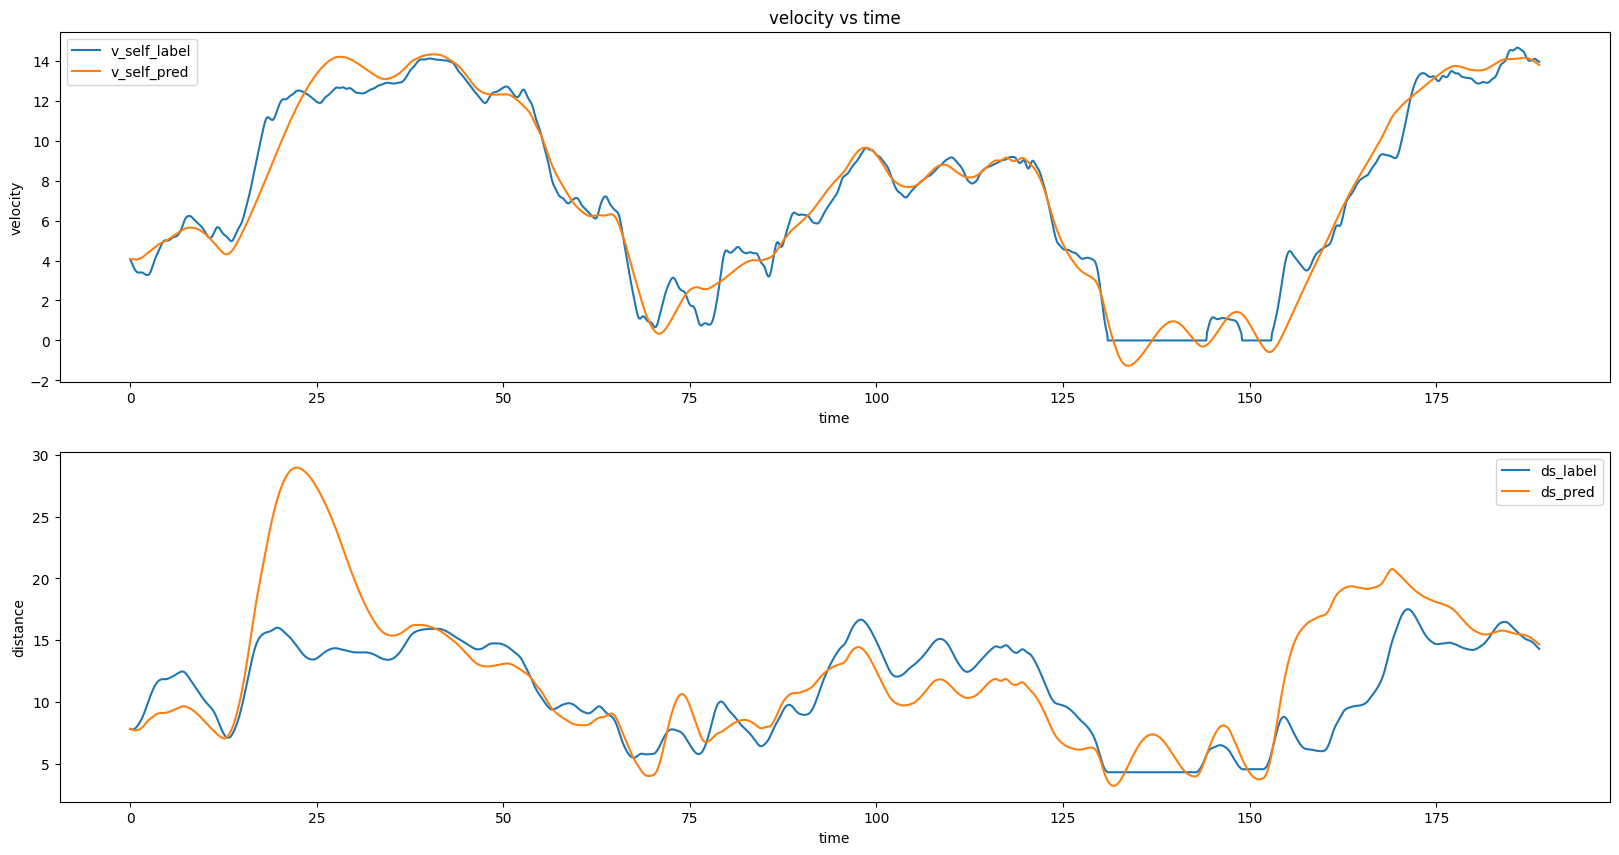

In [15]:
best_ind = tools.selBest(population, 1)[0] # Get the best individual

# Evaluate
plot_estimation(v1, v2, ds12, best_ind)
